## Many contributions 
Repeat the above for 
$$\partial_t u(t,x) = u(t,x) - 3 u(t,x) \partial_x u(t,x) + 0.1 \partial_{xx} u(t,x) - 0.4 \partial_x u(t,x).$$

In [1]:
# prepare mock data - copied from https://docs.sciml.ai/MethodOfLines/dev/tutorials/heat/
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets

# Parameters, variables, and derivatives
@parameters t x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2
Dxxx = Differential(x)^3

# 1D PDE and boundary conditions
eq  = Dt(u(t, x)) ~ u(t,x) - 3 * u(t,x) * Dx(u(t, x)) + 0.1 * Dxx(u(t,x)) - 0.4 * Dx(u(t,x))
bcs = [u(0, x) ~ (exp(- (x-0.5)^2 / (2 * 0.1^2))),
        u(t, 0) ~ u(t, 1)
        ]

# Space and time domains
domains = [t ∈ Interval(0.0, 1.0),
           x ∈ Interval(0.0, 1.0)]

# PDE system
@named pdesys = PDESystem(eq, bcs, domains, [t, x], [u(t, x)])

# Method of lines discretization
dx = 0.002
order = 2 # not used
discretization = MOLFiniteDifference([x => dx], t)

# Convert the PDE problem into an ODE problem
prob = discretize(pdesys, discretization)

# Solve ODE problem
sol = solve(prob, Tsit5(), saveat=0.001)

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines /home/natan/.julia/packages/MethodOfLines/glDxX/src/system_parsing/pde_system_transformation.jl:42


PDESolution:
  Return Code:
    Success
  Dependent variables:
    u(t, x): (1001, 501) sized solution
  Domain:
    t ∈ (0.0, 1.0) with 1001 points, step size 0.001
    x ∈ (0.0, 1.0) with 501 points, step size 0.002
  From system:
    Equations:
    Boundary/Initial Conditions:


L"\begin{align}
 - 0.1 \frac{\mathrm{d}}{\mathrm{d}x} \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + 0.4 \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) + \frac{\mathrm{d}}{\mathrm{d}t} u\left( t, x \right) - u\left( t, x \right) + 3 \frac{\mathrm{d}}{\mathrm{d}x} u\left( t, x \right) u\left( t, x \right) =& 0
\end{align}
"

L"\begin{align}
u\left( 0, x \right) =& e^{ - 50 \left( -0.5 + x \right)^{2}} \\
u\left( t, 0 \right) =& u\left( t, 1 \right)
\end{align}
"

In [2]:
using PDEfind

We pretend that all that is given are the following arrays, which we collect in a grid structure.

In [3]:
# start with given data
time_range = 0.0:0.002:1.0
space_range = 0.0:0.004:1.0
data_array = sol(time_range, space_range)[1]
time_array = collect(time_range)
space_array= collect(space_range)

# initialize grid
g = TimeSpaceGrid1D(time_array, space_array)

TimeSpaceGrid1D{Float64}([0.0, 0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018  …  0.982, 0.984, 0.986, 0.988, 0.99, 0.992, 0.994, 0.996, 0.998, 1.0], [0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036  …  0.964, 0.968, 0.972, 0.976, 0.98, 0.984, 0.988, 0.992, 0.996, 1.0], 0.002, 0.004, 501, 251, 125751, [0.0 0.002 … 0.998 1.0; 0.0 0.002 … 0.998 1.0; … ; 0.0 0.002 … 0.998 1.0; 0.0 0.002 … 0.998 1.0], [0.0 0.0 … 0.0 0.0; 0.004 0.004 … 0.004 0.004; … ; 0.996 0.996 … 0.996 0.996; 1.0 1.0 … 1.0 1.0])

We are solving an equation of the type $\partial_t u_(t,x) = \mathcal L [u(t,x)]$ for unknown $\mathcal L$. 

In this example we assume $\mathcal L$ is a polynomial in $u, \partial_x u, \partial_{xx} u$. Using notation from Rudy et al., we prepare the $\Theta$ matrix. 

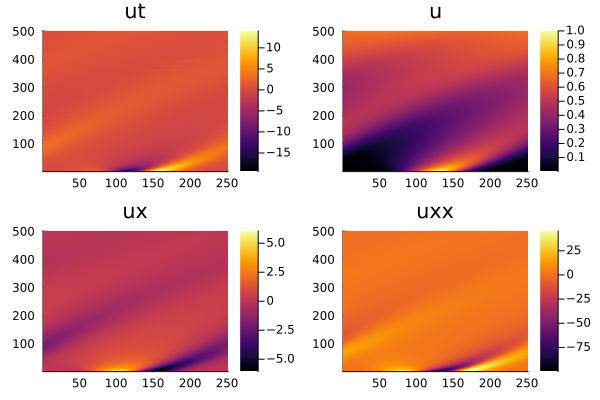

In [4]:
# prepare LHS
# make finite difference operator
∂t = TimeDerivative(g, order=4) # takes BC and order as arguments
dt_data_array = ∂t(data_array) 
dt_data_array_flat = reshape(dt_data_array, g.N) 

# prepare RHS
# construct relevant variables from highest order spatial derivative to consider
∂x = XDerivative(g; order=4, boundary_condition="neumann") # takes BC and order as arguments
max_derivative_degree = 3
variables_matrix = GetVariablesMatrix(max_derivative_degree, data_array, g, ∂x)

# check accuracy of numerical derivatives
using Plots
a,b = 1:size(data_array, 1),1:size(data_array, 2)
# a,b = 1:20,1:25
p1 = heatmap(reshape(dt_data_array_flat ,(g.nt,g.nx))[a,b], title="ut")
p2 = heatmap(reshape(variables_matrix[1],(g.nt,g.nx))[a,b], title="u")
p3 = heatmap(reshape(variables_matrix[2],(g.nt,g.nx))[a,b], title="ux")
p4 = heatmap(reshape(variables_matrix[3],(g.nt,g.nx))[a,b], title="uxx")
plot(p1, p2, p3, p4, layout = (2,2))

In [5]:
# construct basis functions, eg: polynomial basis
max_poly_degree = 2
n_variables = max_derivative_degree + 1 # include 0th-derivative i.e. function itself
MyBasis = PolynomialBasis(max_poly_degree, n_variables, skip_constant = false)

# theta matrix
Θ = evaluate(MyBasis, variables_matrix)
# cond_number = norm(Θ,2) * norm(pinv(Θ),2)

125751×15 Matrix{Float64}:
 1.0  3.72665e-6    0.000186285   0.0089155  …   0.00394137   0.195436
 1.0  8.89215e-6   -2.5289e-5     0.0303101      0.00136785   0.00203657
 1.0  1.60943e-5   -6.32638e-5    0.0391492     -0.00245391   0.00392891
 1.0  2.59432e-5   -0.000126447   0.0527041     -0.0084391    0.0256391
 1.0  3.84906e-5   -0.000225816   0.0707101     -0.0203507    0.0828317
 1.0  5.52055e-5   -0.000371248   0.0931301  …  -0.0425308    0.208558
 1.0  7.70815e-5   -0.000575374   0.120407      -0.0810737    0.453378
 1.0  0.000105203  -0.000852454   0.152987      -0.144415     0.89108
 1.0  0.000140757  -0.00121836    0.191295      -0.243872     1.62522
 1.0  0.000185028  -0.00169057    0.235728      -0.39424      2.79706
 ⋮                                           ⋱               
 1.0  0.67271       0.092007     -0.349573       1.27484     13.2996
 1.0  0.673569      0.093655     -0.319893       1.13774     12.6497
 1.0  0.674403      0.0946762    -0.299045       1.06164    

Perform sequential thresholded ridge regression at *fixed threshold* and *fixed* $\lambda$.

In [6]:
# perform ridge regression
STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol = 5e-2, iters = 4, verbose = true, normalize_columns = false)

Iteration: 4, threshold: 0.05. 
Iteration: 3, threshold: 0.05. 
Iteration: 2, threshold: 0.05. 
Iteration: 1, threshold: 0.05. 


Current fit: 
 $ \\ \partial_t u = \textcolor{grey}{\xi_{0000}} + \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \textcolor{grey}{\xi_{0001}\partial_{xxx} u} + \textcolor{grey}{\xi_{2000}(u)^2} + \xi_{1100}u\partial_{x} u + \textcolor{grey}{\xi_{1010}u\partial_{xx} u} + \textcolor{grey}{\xi_{1001}u\partial_{xxx} u} + \textcolor{grey}{\xi_{0200}(\partial_{x} u)^2} + \textcolor{grey}{\xi_{0110}\partial_{x} u\partial_{xx} u} + \textcolor{grey}{\xi_{0101}\partial_{x} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0020}(\partial_{xx} u)^2} + \textcolor{grey}{\xi_{0011}\partial_{xx} u\partial_{xxx} u} + \textcolor{grey}{\xi_{0002}(\partial_{xxx} u)^2} \\ $ with: $ \\\textcolor{grey}{\xi_{0000} = 0.005 \\ }\xi_{1000} = 0.995 \\ \xi_{0100} = -0.408 \\ \xi_{0010} = 0.1 \\ \textcolor{grey}{\xi_{0001} = 0.0 \\ }\textcolor{grey}{\xi_{2000} = -0.014 \\ }\xi_{1100} = -2.973 \\ \textcolor{grey}{\xi_{1010} = 0.005 \\ }\textcolor{grey}{\xi_{1001} = 0.0 \\ }\textcolor{grey}{\xi_{0200} = -0.001 \\ }\textcolor{grey}{\xi_{0110} = 0.0 \\ }\textcolor{grey}{\xi_{0101} = -0.0 \\ }\textcolor{grey}{\xi_{0020} = 0.0 \\ }\textcolor{grey}{\xi_{0011} = 0.0 \\ }\textcolor{grey}{\xi_{0002} = 0.0 \\ }$ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{1000} = 0.993 \\ \xi_{0100} = -0.397 \\ \xi_{0010} = 0.102 \\ \xi_{1100} = -3.004 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{1000} = 0.993 \\ \xi_{0100} = -0.397 \\ \xi_{0010} = 0.102 \\ \xi_{1100} = -3.004 \\ $ 
 - - -

Current fit: 
 $ \\ \partial_t u = \xi_{1000}u + \xi_{0100}\partial_{x} u + \xi_{0010}\partial_{xx} u + \xi_{1100}u\partial_{x} u \\ $ with: $ \\\xi_{1000} = 0.993 \\ \xi_{0100} = -0.397 \\ \xi_{0010} = 0.102 \\ \xi_{1100} = -3.004 \\ $ 
 - - -

([0.9932984917521034, -0.39660454064304085, 0.10205796140328932, -3.004051847573975], Any[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 1, 0, 0]])

The threshold landscape exploration. 

In [7]:
using LinearAlgebra, Plots
N = g.N
cond_number = cond(Θ, 2)

tol_range = 10.0 .^ (-5:1e-2:1.0)
L2_error²_array = zero(tol_range)
L0_error²_array = zero(tol_range)

for (i,tol) in enumerate(tol_range)
    ξ, active_poly_vectors = STRidge_cascade(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ=1e-5, tol=tol, iters=4)
    chosen_mask = MyBasis.poly_vectors .∈ Ref(active_poly_vectors)
    L2_error²_array[i] = norm(Θ[:, chosen_mask] * ξ - dt_data_array_flat, 2)^2
    L0_error²_array[i] = norm(ξ, 0)^2
end

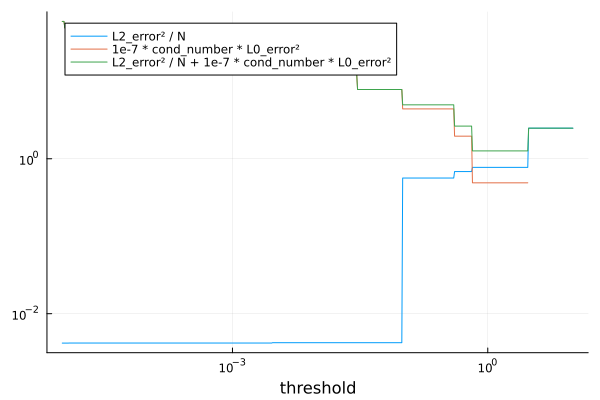

In [9]:
plot(tol_range, L2_error²_array ./ N, xscale=:log10, yscale=:log10, label="L2_error² / N", xlabel="threshold", legend=:topleft)
plot!(tol_range[L0_error²_array .> 0.], 1e-7 .* cond_number .* L0_error²_array[L0_error²_array .> 0.], label="1e-7 * cond_number * L0_error²")
plot!(tol_range, L2_error²_array ./ N + 1e-7 .* cond_number .* L0_error²_array, label="L2_error² / N + 1e-7 * cond_number * L0_error²")

Perform the choice of optimal threshold at *fixed* $\lambda$.

In [9]:
TrainSTRidge(Θ, dt_data_array_flat, MyBasis.poly_vectors, λ = 1e-5, tol_multiplier=1.0, iters = 5, verbose = true, cond_number_multiplier=1e-6,  max_tol_iters = 40)

Split input data to 100601 train and 25150 test samples. 
Using η = 1.0e-6 * 4.891503392162506e6. 
tol_iter = 1: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-3.5181502229246484]. Decreased Threshold to 2.7760531477886956. 
tol_iter = 2: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-3.5181502229246484]. Decreased Threshold to 1.3880265738943478. 
tol_iter = 3: Found better/equal fit with polynomials Any[[1, 1, 0, 0]], xi = [-3.5181502229246484]. Decreased Threshold to 0.6940132869471739. 
tol_iter = 4: Stepsize too big. Decreased tol_multiplier to 0.5. 
tol_iter = 5: Found better/equal fit with polynomials Any[[1, 0, 0, 0], [1, 1, 0, 0]], xi = [0.6333702227486504, -3.5372306491402923]. Decreased Threshold to 0.4626755246314493. 
tol_iter = 6: Found better/equal fit with polynomials Any[[1, 0, 0, 0], [0, 1, 0, 0], [1, 1, 0, 0]], xi = [0.6493404741984701, -0.7865435263844222, -1.962594605494737]. Decreased Threshold to 0.3084503497542995. 
tol_iter

([0.992856390836962, -0.39852306657895237, 0.10215880810395389, -3.000368660935895], Any[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [1, 1, 0, 0]])

Investigate behaviour at different $\lambda$.

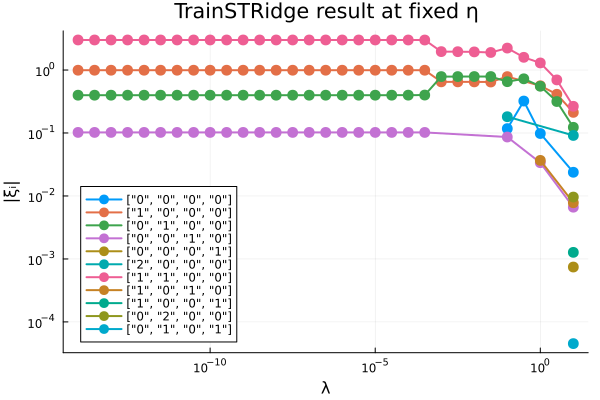

In [10]:
lambda_range = 10.0 .^ (-14.0:0.5:1.0)
to_plot = lambda_sweep(lambda_range, Θ, dt_data_array_flat, MyBasis.poly_vectors, iters=5)

using Plots
plt = plot(legend=:bottomleft, xlabel="λ", ylabel="|ξᵢ|", title="TrainSTRidge result at fixed η")
for i in 1:length(MyBasis.poly_vectors)
    try
        plot!(to_plot[i,1], abs.(to_plot[i,2]), label=MyBasis.poly_vectors[i], xscale=:log10, yscale=:log10, linewidth=2, marker=:circle, markersize=6, markerstrokewidth=0)
    catch
    end
end
display(plt)